<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 6 - LSTM&GRU 
**Nome:**

**Numero Usp:**









______________




O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando GRU's e LSTM's. Essa lista é semelhante a lista 03 onde aprendemos a usar embeddings e onde você ja recebeu a arquitetura do seu modelo quase pronta. A diferença é que desta vez você ira construir sozinho sua rede e utilizará as camadas que acabamos de aprender: LSTM e GRU.
 
Essa tambêm será a primeira rede recorrente que montaremos, portanto a tokenização será ligeiramente diferente (por exemplo o padding não é mais necessário.)

In [33]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('portuguese')
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
tf.__version__

'2.2.1'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte de 10 mil linhas do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [35]:
b2wCorpus = pd.read_csv("../Semana 03/data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [36]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


## Pré-processamento 
# <font color='blue'>Questão 1 </font>
Copie suas etapas de préprocessamento da lista 03, ou seja, selecione apenas as colunas relevantes ("review_text" e "recommend_to_a_friend"), converta a coluna "review_text" de uma coluna de `str` para uma coluna de `int` e separe os dados em teste e treino.


In [37]:
b2wCorpus= b2wCorpus[["review_text", "recommend_to_a_friend"]]
b2wCorpus['recommend_to_a_friend'].replace({'No': 0, 'Yes': 1}, inplace = True)
b2wCorpus.head()
b2wCorpus["recommend_to_a_friend"].value_counts()

1    7451
0    2548
Name: recommend_to_a_friend, dtype: int64

In [38]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [39]:
df_neg=b2wCorpus.query('recommend_to_a_friend==0')
df_pos=b2wCorpus.query('recommend_to_a_friend==1')

In [40]:
df_pos.head()

,review_text,recommend_to_a_friend
0,contente compra entrega r pida nico problema a...,1
1,apenas r 1994 20 consegui comprar lindo copo a...,1
2,supera agilidade praticidade outras panelas el...,1
3,filho amou parece verdade tantos detalhes t m,1
4,entrega prazo americanas est parab ns smart tv...,1


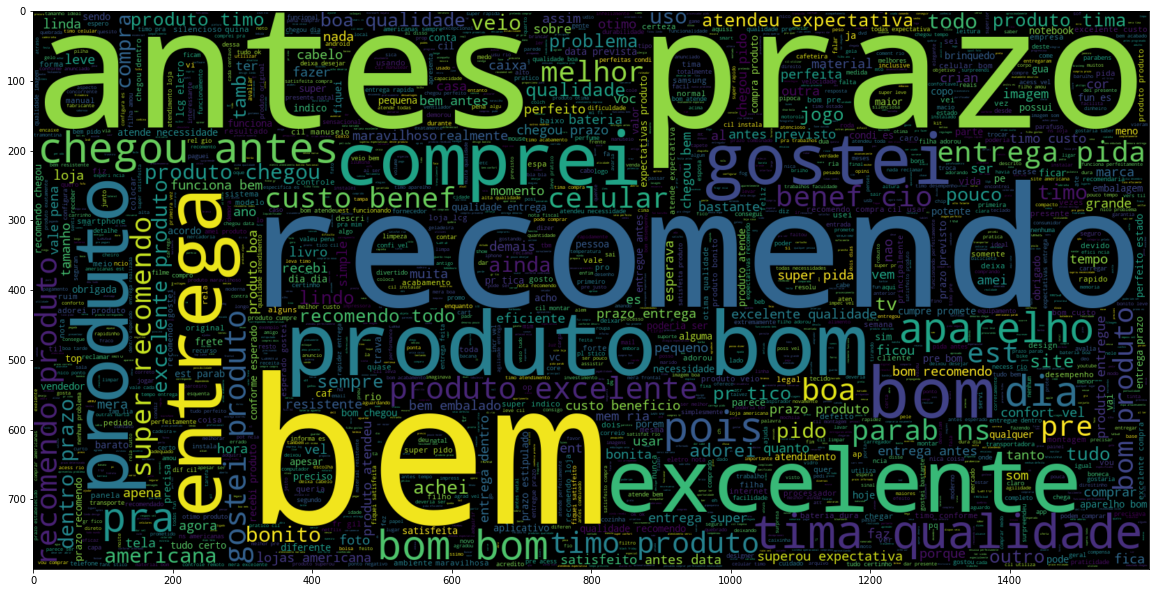

In [41]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_pos[df_pos.recommend_to_a_friend == 1].review_text))
plt.imshow(wc , interpolation = 'bilinear')

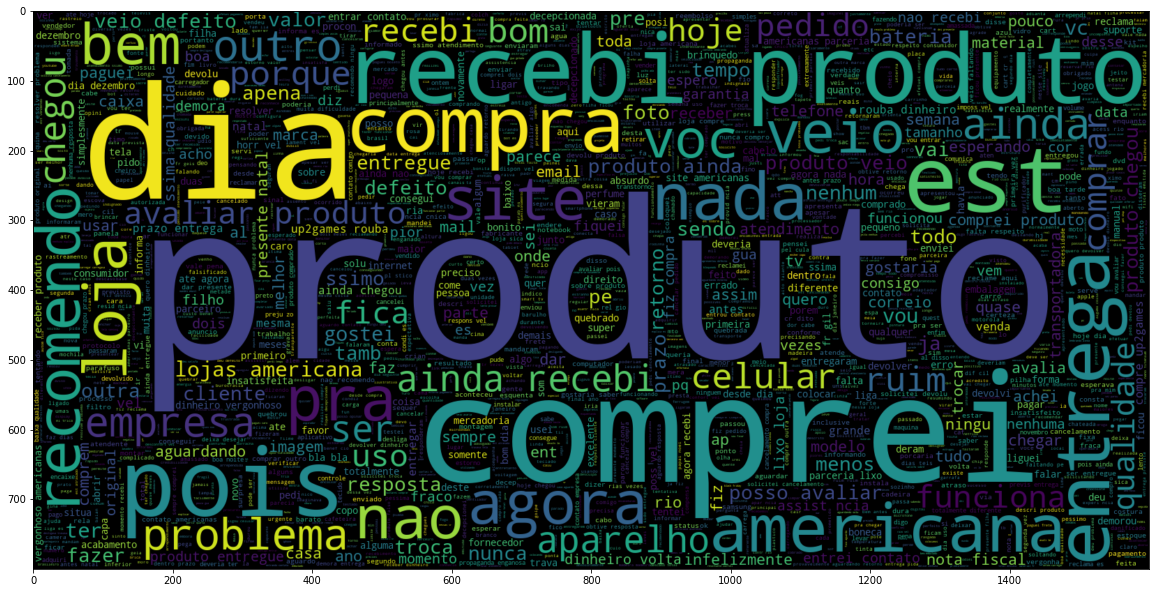

In [42]:
df_neg.head()
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_neg[df_neg.recommend_to_a_friend == 0].review_text))
plt.imshow(wc , interpolation = 'bilinear')

In [43]:
df=pd.concat([df_neg,df_pos.head(2548)],axis=0)
df.head()

,review_text,recommend_to_a_friend
9,produto nao entregue americanas descontando fa...,0
12,jogo panelas excelente material entrega tempo ...,0
13,celular n vale nada bateria n vale nada descar...,0
15,mochila nao fechando direito nao recomendo fil...,0
25,n recebi produto americanas sabe disso pois j ...,0


In [44]:
df["recommend_to_a_friend"].value_counts()

1    2548
0    2548
Name: recommend_to_a_friend, dtype: int64

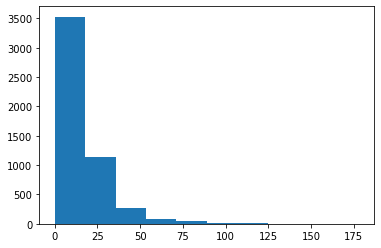

In [45]:
plt.hist([len(linha.split()) for linha in df["review_text"]])
plt.show()

In [46]:
x = df[['review_text']].values
y = df[['recommend_to_a_friend']].values

print(df.recommend_to_a_friend.value_counts()/ df.shape[0])

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

1    0.5
0    0.5
Name: recommend_to_a_friend, dtype: float64


## Tokenizando




# <font color='blue'>Questão 2 </font>
Utilizando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) tokenize os inputs.
Declare a camada e então chame a função `adapt()` no seu conjunto de treino para adequar o seu vocabulário aos reviews. 

Note que o uso de padding não é mais necessario.

In [47]:

vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=100
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)

8155


## LSTM&GRU

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

#  <font color='blue'>Questão 3 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas  [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?




**<font color='red'> Sua resposta aqui </font>**

In [48]:
model = keras.Sequential()
model.add(vectorize_layer)
model.add(keras.layers.Embedding(vocab_size + 2, 128, input_length=100))
model.add(keras.layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(keras.layers.LSTM(96, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=10, validation_split=0.1)

Epoch 1/20
367/367 [==============================] - 19s 51ms/step - loss: 0.6940 - accuracy: 0.5046 - val_loss: 0.6918 - val_accuracy: 0.5343
Epoch 2/20
367/367 [==============================] - 18s 49ms/step - loss: 0.6937 - accuracy: 0.4945 - val_loss: 0.6927 - val_accuracy: 0.5343
Epoch 3/20
 82/367 [=====>........................] - ETA: 13s - loss: 0.6935 - accuracy: 0.5085

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

#  <font color='blue'>Questão 4 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?


In [ ]:
model = keras.Sequential()
model.add(vectorize_layer)
model.add(keras.layers.Embedding(vocab_size + 2, 128, input_length=100))
model.add(keras.layers.GRU(64, dropout=0.5, return_sequences=True))
model.add(keras.layers.GRU(96, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Redes Bi-direcionais
#  <font color='blue'>Questão 5 </font>

a) Defina, compile, treine e avalie um novo modelo que utilize contexto em ambas as direções usando a camada [`Bidirectional()`](https://keras.io/api/layers/recurrent_layers/bidirectional/), seja com camadas GRU ou LSTM.


b) Como foi sua performance em relação as questões anteriores com contexto unidirecional?

**<font color='red'> Sua resposta aqui </font>**

In [ ]:
# Seu código aqui